## This notebook contains implementation of artificial neural network for classical problem of handwritten digit recognition using plain python without any neural network libraries.
## The dataset is the MNIST dataset with 60000 training examples and 10000 test examples. Each training and test example is the grey-scaled image of 28x28 pixels.
## Using two hidden layers, the accuracy on the test set of 97.35% achieved over the training through 60 epochs with mini-batch size of 10 samples and sigmoids as activation function in each layer
## Cost function - root mean square error, activation functions - sigmoid

In [1]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
%matplotlib notebook

## Importing MNIST data and converting them to numpy arrays

In [2]:
file_imag_train='train-images.idx3-ubyte'
file_label_train='train-labels.idx1-ubyte'
file_imag_test='t10k-images.idx3-ubyte'
file_label_test='t10k-labels.idx1-ubyte'
data_imag=idx2numpy.convert_from_file(file_imag_train)
data_labels=idx2numpy.convert_from_file(file_label_train)
data_imag_test=idx2numpy.convert_from_file(file_imag_test)
data_labels_test=idx2numpy.convert_from_file(file_label_test)

In [3]:
print("Shape of array containing digit pixels: {0}".format(data_imag.shape))
print("Shape of array containing digit labels: {0}".format(data_labels.shape))

Shape of array containing digit pixels: (60000, 28, 28)
Shape of array containing digit labels: (60000,)


## Draw some digits

<IPython.core.display.Javascript object>


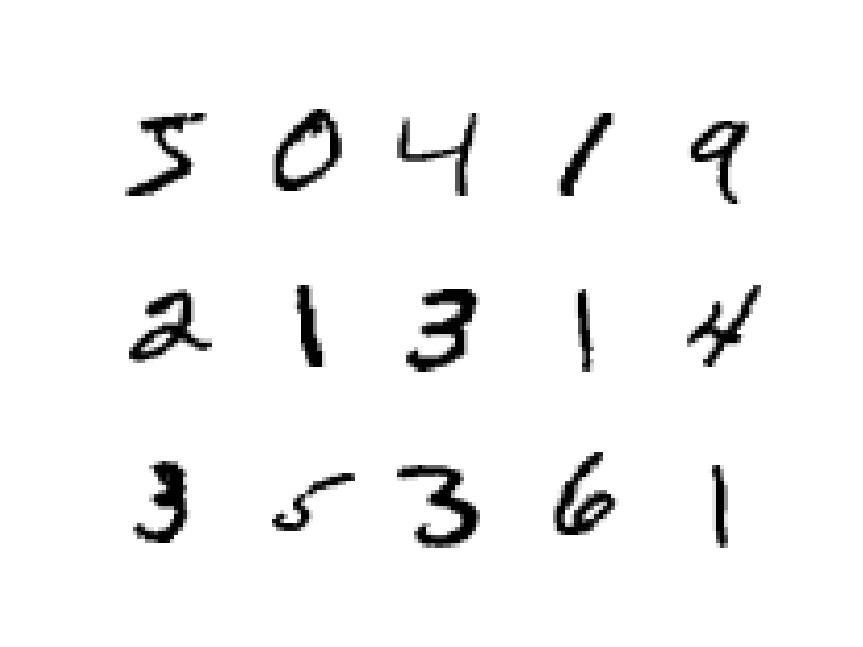

In [4]:
for index in range(15):
    plt.subplot(3,5,index+1)
    plt.axis('off')
    plt.imshow(data_imag[index],cmap=plt.cm.gray_r,interpolation='nearest')

## Reshape 2-dim 28x28 pixels image to 1-dim 784 pixels array

In [5]:
data_imag_reshaped=np.reshape(data_imag, (data_imag.shape[0], data_imag.shape[1]*data_imag.shape[2]))
data_imag_test_reshaped=np.reshape(data_imag_test, (data_imag_test.shape[0], data_imag_test.shape[1]*data_imag_test.shape[2]))
inputs=data_imag_reshaped.T
inputs_test=data_imag_test_reshaped.T

## Converting labels from training set to column vectors of size 10

In [6]:
labels=data_labels.T
labels_test=data_labels_test.T
one_hot_labels=np.zeros((10, labels.shape[0]))
for i in range(labels.shape[0]):
    one_hot_labels[labels[i], i]=1
print("Original labels: {0}".format(labels[:10]))
print("One hot encoded labels:\n {0}".format(one_hot_labels[:, :10]))

Original labels: [5 0 4 1 9 2 1 3 1 4]
One hot encoded labels:
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Scaling all the pixels to unifrom range

In [7]:
X_train=inputs
y_train=one_hot_labels
X_test=inputs_test
y_test=labels_test
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.T).T
X_test = sc.transform(X_test.T).T

## Initializing network parameters

In [8]:
network_architecture=[X_train.shape[0], 100, 10] # [input nodes, hidden layer1, ..., hidden layer n, output_layer]
mini_batch_size=10 # Size of mini-batch for stochastic gradient descent approach
learning_rate=0.1
regularization=5
epochs=60 # number of epochs to train

In [9]:
number_training_examples=X_train.shape[1]
number_inputs=network_architecture[0]
number_output=network_architecture[-1]
number_hidden_layers=len(network_architecture)-2
number_mini_batches=number_training_examples/mini_batch_size

## Initialize each weight using a Gaussian distribution with mean 0 and standard deviation 1 over the square root of the number of weights connecting to the same neuron.  Initialize the biases using a Gaussian distribution with mean 0 and standard deviation 1

In [10]:
weights=[]
bias=[]
for i in range(number_hidden_layers+1):
    weights.append(np.random.rand(network_architecture[i+1],network_architecture[i])/np.sqrt(network_architecture[i]))
    bias.append(np.random.rand(network_architecture[i+1], 1))

## Utility functions

In [11]:
def shuffle_data(x,y): # shuffle data for stochastic gradient descent
    randomize=np.arange(x.shape[1])
    np.random.shuffle(randomize)
    x=x[:,randomize]
    y=y[:,randomize]
    return x, y
def net(x, w, b): # dot product of weights and corresponding inputs
    return np.dot(w, x)+b
def sigmoid(x): # logistic activation function
    return 1.0/(1.0+np.exp(-x))
def sigmoid_der(x): # Derivative of logistic activation function
    return sigmoid(x)*(1.0-sigmoid(x))
# Forward propgating function in Neural network
def forward_propagation(x,w,b, n_hidden_layers):
    nets=[None]*(number_hidden_layers+1)
    activations=[None]*(number_hidden_layers+1)
    activations_der=[None]*(number_hidden_layers+1)
    nets[0]=net(x, w[0], b[0])
    activations[0]=sigmoid(nets[0])
    activations_der[0]=sigmoid_der(nets[0])
    for k in range(n_hidden_layers):
        net_temp=net(activations[k], weights[k+1], bias[k+1])
        nets[k+1]=net_temp
        activations[k+1]=sigmoid(net_temp)
        activations_der[k+1]=sigmoid_der(net_temp)
    return activations, activations_der # return activations for all layers and its derivative
# Backword propagation function in Neral network
def backpropagation(x, y, a, a_der, n_hidden_layers):
    dError_dWeights=[None]*(number_hidden_layers+1)
    dError_dWeights_bias=[None]*(number_hidden_layers+1)
    error_output=a[-1]-y      
    delta=error_output*a_der[-1] # the case for meas square error cost function
    #delta=error_output # the case for cross entropy cost function
    dError_dWeights[-1]=np.dot(delta, a[-2].T)
    dError_dWeights_bias[-1]=np.sum(delta, axis=1, keepdims=True)
    for k in range(n_hidden_layers):
        delta=np.dot(weights[-(k+1)].T, delta)*a_der[-(k+2)]
        dError_dWeights_bias[-(k+2)]=np.sum(delta, axis=1, keepdims=True)
        if k==n_hidden_layers-1:
            dError_dWeights[-(k+2)]=np.dot(delta, x.T)
        else:
            dError_dWeights[-(k+2)]=np.dot(delta, a[-(k+3)].T)
    return dError_dWeights, dError_dWeights_bias
 # return partial derivatives of cost function with repsect to all weights and biases for all layers

## Main block. Here we go through epochs and within each epoch we run through all mini-batches and update weights and biases for each mini-batch. then within each epoch we calculate predicted digits for test set with given weights and biases. Ratio of correctly predicted digits to total amont of digits is printed

In [12]:
out_test=[None]*(number_hidden_layers+1)
cost=np.array([])

# Initializing graph to plot cost function evolution
# iteration=np.array([])
# import matplotlib.pyplot as plt
# %matplotlib notebook
# plt.ion()
# fig1, ax1=plt.subplots()
for epoch in range(epochs):
    # Splitting training set into minibatches
    X_train, y_train=shuffle_data(X_train, y_train)
    X_train_minibatches=[X_train[:, i:i+mini_batch_size] for i in range(0, number_training_examples, mini_batch_size)]
    y_train_minibatches=[y_train[:, i:i+mini_batch_size] for i in range(0, number_training_examples, mini_batch_size)]
    
    # Calclating new weights and biases for each mini-batch
    for i in range(len(X_train_minibatches)):            
        # Feedforward step
        activations, activations_der=forward_propagation(X_train_minibatches[i],weights,bias, number_hidden_layers)
        ############################################
        # Backpropagation step
        dError_dWeights, dError_dWeights_bias=backpropagation(X_train_minibatches[i], y_train_minibatches[i], activations, activations_der, number_hidden_layers)
        
        # Updating weights using also regularization parameters
        for k in range(number_hidden_layers+1):
            weights[k]=(1-learning_rate*regularization/number_training_examples)*weights[k]-1/mini_batch_size*learning_rate*dError_dWeights[k]
            bias[k] =bias[k]-1/mini_batch_size*learning_rate*dError_dWeights_bias[k]
        ## The block to plot costs within one epoch
        ########
#         out_test[0]=sigmoid(net(X_test, weights[0], bias[0]))
#         for k in range(number_hidden_layers):
#             out_test[k+1]=sigmoid(net(out_test[k], weights[k+1], bias[k+1]))
#         error=1/len(labels)*np.sum(0.5*(out_test[-1]-y_test)**2)
#         cost=np.append(cost, error)
#         iteration=np.append(iteration, i)
#         ax1.plot(iteration, cost)
#         fig1.canvas.draw()
        ########
    # making predictions for test test
    out_test[0]=sigmoid(net(X_test, weights[0], bias[0]))
    for k in range(number_hidden_layers):
        out_test[k+1]=sigmoid(net(out_test[k], weights[k+1], bias[k+1]))    
    labels_predicted=np.argmax(out_test[-1], axis=0) # predicted digits for test set
    correctly_predicted=np.sum(labels_predicted==y_test) # calculating amount of correctly predicted digits
    print("Epoch {0}: {1} / {2}".format(epoch, correctly_predicted, len(y_test)))

Epoch 0: 9148 / 10000
Epoch 1: 9293 / 10000
Epoch 2: 9373 / 10000
Epoch 3: 9415 / 10000
Epoch 4: 9456 / 10000
Epoch 5: 9478 / 10000
Epoch 6: 9503 / 10000
Epoch 7: 9503 / 10000
Epoch 8: 9537 / 10000
Epoch 9: 9542 / 10000
Epoch 10: 9555 / 10000
Epoch 11: 9574 / 10000
Epoch 12: 9570 / 10000
Epoch 13: 9578 / 10000
Epoch 14: 9589 / 10000
Epoch 15: 9594 / 10000
Epoch 16: 9598 / 10000
Epoch 17: 9608 / 10000
Epoch 18: 9615 / 10000
Epoch 19: 9608 / 10000
Epoch 20: 9621 / 10000
Epoch 21: 9627 / 10000
Epoch 22: 9639 / 10000
Epoch 23: 9631 / 10000
Epoch 24: 9645 / 10000
Epoch 25: 9637 / 10000
Epoch 26: 9649 / 10000
Epoch 27: 9651 / 10000
Epoch 28: 9652 / 10000
Epoch 29: 9647 / 10000
Epoch 30: 9656 / 10000
Epoch 31: 9654 / 10000
Epoch 32: 9652 / 10000
Epoch 33: 9656 / 10000
Epoch 34: 9658 / 10000
Epoch 35: 9666 / 10000
Epoch 36: 9667 / 10000
Epoch 37: 9665 / 10000
Epoch 38: 9674 / 10000
Epoch 39: 9672 / 10000
Epoch 40: 9673 / 10000
Epoch 41: 9677 / 10000
Epoch 42: 9676 / 10000
Epoch 43: 9677 / 1000